In [4]:
#mv_model_rotation_error.sql
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns
from funclib.iolib import folder_open
from dblib import mssql
from plotlib.mplfuncs import FigWidthsInch as Size
from scipy import stats
W = Size.one_and_a_half_col.value
H = W*0.667

sns.set()

#gey = ["#FFFFFF", "#999999", "#666666", "#333333", "#000000"]
#grey = ["#FFFFFF", "#111111"]
#sns.set_palette(sns.color_palette("cubehelix", 8))

sns.set(font="Times New Roman", font_scale=1.2, rc={"lines.linewidth": 1, "figure.figsize":(W, H)}) #
sns.set_style('ticks') #rc={'axes.grid':True}
print('*OK*')


In [5]:
sql = "select CNN ,Transform ,rotation as Angle,Scale,persp_corr_iter_profile_tridist_mm_error as [Manual error],persp_corr_iter_profile_tridist_mm_error_perc as [Manual error %],mv_persp_corr_iter_profile_tridist_mm_error as [MV error],mv_persp_corr_iter_profile_tridist_mm_error_perc as [MV error %],all_corr_rot_adj2_mm_error as [MV adjusted error],all_corr_rot_adj2_mm_error_perc as [% MBE], accuracy as Score from v_mv_long_form where (transform = 'None' or rotation != 0) and not mv_persp_corr_iter_profile_tridist_mm_error is null and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df = pd.read_sql(sql, cnn)
list(df)


['CNN',
 'Transform',
 'Angle',
 'Scale',
 'Manual error',
 'Manual error %',
 'MV error',
 'MV error %',
 'MV adjusted error',
 '% MBE',
 'Score']

In [6]:
sql = "select CNN ,Transform ,rotation as Angle,Scale,persp_corr_iter_profile_tridist_mm_error as [Manual error],persp_corr_iter_profile_tridist_mm_error_perc as [Manual error %],mv_persp_corr_iter_profile_tridist_mm_error as [MV error],mv_persp_corr_iter_profile_tridist_mm_error_perc as [MV error %],all_corr_rot_adj2_mm_error as [MV adjusted error],all_corr_rot_adj2_mm_error_perc as [MV adjusted error %], accuracy as Score from v_mv_long_form where (transform = 'None' or rotation != 0)"
with mssql.Conn('imagedb', '(local)') as cnn:
    df_score = pd.read_sql(sql, cnn)
list(df_score)

['CNN',
 'Transform',
 'Angle',
 'Scale',
 'Manual error',
 'Manual error %',
 'MV error',
 'MV error %',
 'MV adjusted error',
 'MV adjusted error %',
 'Score']

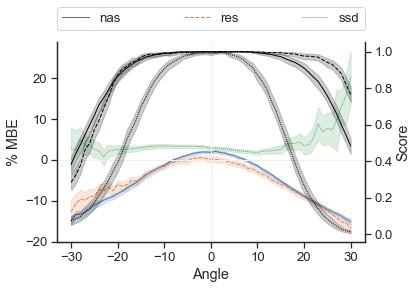

In [7]:
#mv_model_rotation_error.sql
#score > 0.5
g = sns.lineplot(x='Angle', y='% MBE', hue='CNN', style='CNN', data=df, legend=False)
g.legend(g.lines, ('nas', 'res', 'ssd'), bbox_to_anchor=(0,1.02,1,0.2), loc="center left", mode="expand", borderaxespad=0, ncol=3, title='')
ax_score = g.twinx()

sns.lineplot(x='Angle', y='Score', hue='CNN', style='CNN', data=df_score, ax=ax_score, palette=['#000000','#000000','#000000'], linewidth=1)

g.axvline(x=0, aa=False, color='#F0F0F0', linewidth=0.5)
g.axhline(y=0, aa=False, color='#F0F0F0', linewidth=0.5 )
ax_score.legend_.remove()
sns.despine(top=True, right=False)
#plt.tight_layout()



plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/rotation_mbe.svg', bbox_inches='tight')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/rotation_mbe.jpg', bbox_inches='tight', dpi=1200)
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')


In [ ]:
#SEPERATOR - VALID/INVALID

In [89]:
sql="SELECT good.cnn as CNN ,abs(good.rotation) AS Angle ,(good_cnt / (good_cnt + isnull(bad_cnt, 0) + 0.000001)) * 100 AS [Valid %] FROM ( SELECT count(*) AS good_cnt ,cnn ,rotation FROM v_mv_long_form WHERE accuracy >= 0.5 and (transform like 'r%' or transform='None') GROUP BY rotation,cnn ) AS good LEFT JOIN ( SELECT count(*) AS bad_cnt ,cnn ,rotation FROM v_mv_long_form WHERE accuracy < 0.5 and (transform like 'r%' or transform='None') GROUP BY rotation, cnn ) AS bad ON good.rotation = bad.rotation and good.cnn=bad.cnn ORDER BY good.cnn, good.rotation ASC"
with mssql.Conn('imagedb', '(local)') as cnn:
    df_valid = pd.read_sql(sql, cnn)
list(df_valid)

['CNN', 'Angle', 'Valid %']

In [ ]:
g = sns.lineplot(x='Angle', y='Valid %', hue='CNN', style='CNN', data=df_valid)
#ax_score = g.twinx()
g.axvline(x=0, aa=False, color='#F0F0F0', linewidth=0.5)
#g.axhline(y=0, aa=False, color='#F0F0F0', linewidth=0.5 )


#sns.lineplot(x="Scale", y="Score", data=df, ax=ax_score)
#ax_scoreShore1.set_ylim(50, 100)

sns.despine()
plt.tight_layout()



plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/rotation_valid.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/rotation_valid.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')


In [ ]:
#AGGREGATES

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

list(df)

In [8]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def mse(pred):
    def mse_(est):
        ndpred = np.zeros(est.shape[0]) + pred
        return mean_squared_error(ndpred, est)
    mse_.__name__ = 'mse_%s' % pred
    return mse_


def ci(data):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + 0.95) / 2., n-1)
    s = 'M=%0.1f 95%% CIs [%0.1f, %0.1f]' % (m, m-h, m+h)
    #return m, m-h, m+h
    return s

In [ ]:
#SPACER

In [86]:
sql = "select CNN ,Transform ,abs(rotation) as Angle,Scale,persp_corr_iter_profile_tridist_mm_error as [Manual error],persp_corr_iter_profile_tridist_mm_error_perc as [Manual error %],mv_persp_corr_iter_profile_tridist_mm_error as [MV error],mv_persp_corr_iter_profile_tridist_mm_error_perc as [MV error %],all_corr_rot_adj2_mm_error as [MV adjusted error],all_corr_rot_adj2_mm_error_perc as [MV adjusted error %], accuracy as Score from v_mv_long_form where (transform = 'None' or rotation != 0) and not mv_persp_corr_iter_profile_tridist_mm_error is null and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    dfabs = pd.read_sql(sql, cnn)
list(dfabs)

['CNN',
 'Transform',
 'Angle',
 'Scale',
 'Manual error',
 'Manual error %',
 'MV error',
 'MV error %',
 'MV adjusted error',
 'MV adjusted error %',
 'Score']

In [84]:
#Unadjusted
unadj = dfabs.groupby(['CNN', 'Angle']).agg({'MV error %':[np.mean, np.std, np.median, percentile(25), percentile(75), mse(0)]})
unadj.to_excel('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/rot_unadjusted.xlsx')
print('Done')

Done


In [87]:
#Adjusted
adj = dfabs.groupby(['CNN', 'Angle']).agg({'MV adjusted error %':[np.mean, np.std, np.median, percentile(25), percentile(75), mse(0)]})
adj.to_excel('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/rot_adjusted.xlsx')
print('Done')

Done


In [ ]:
#SPACER - VALID/AGGREGATE

In [90]:
#Unadjusted
#['CNN', 'Angle', 'Valid %']
valid = df_valid.groupby(['CNN', 'Angle']).agg({'Valid %':[np.mean, np.std, np.median, percentile(25), percentile(75), mse(0)]})
valid.to_excel('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/rot_valid.xlsx')
print('Done')

Done


In [ ]:
#SPACER - Patterns for modelling

In [113]:
sql="select tl_mm, lens_subj_triangle_est, abs(rotation) as rotation ,accuracy ,hw_ratio, all_corr_rot_adj2_mm_error_perc as bias_percent, abs(all_corr_rot_adj2_mm_error_perc) as abs_bias_percent from v_mv_long_form where cnn = 'nas' and (transform like 'r%' or transform like 'none') and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df_hwratio = pd.read_sql(sql, cnn)
list(df_hwratio)

['tl_mm',
 'lens_subj_triangle_est',
 'rotation',
 'accuracy',
 'hw_ratio',
 'bias_percent',
 'abs_bias_percent']

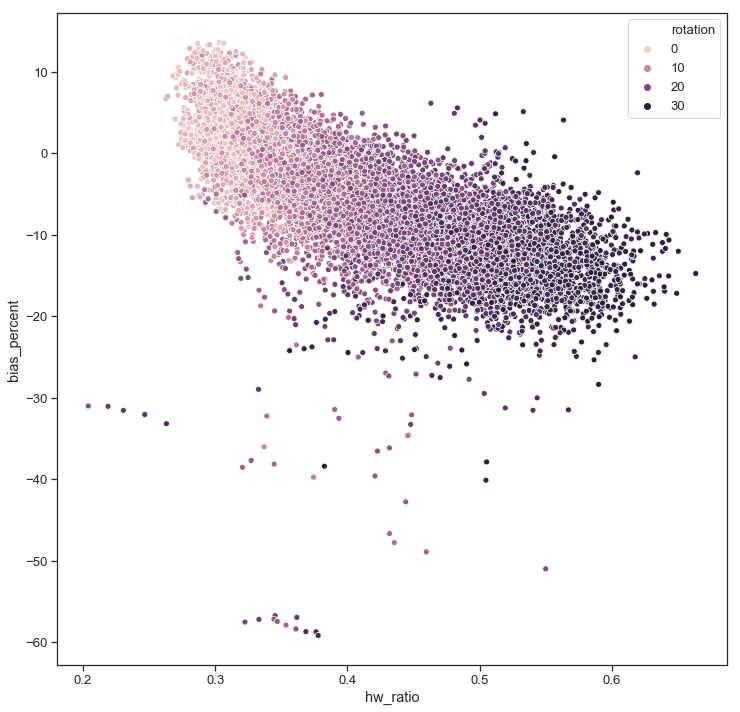

In [120]:
g = sns.scatterplot(x='hw_ratio', y='bias_percent', hue='rotation', data=df_hwratio)

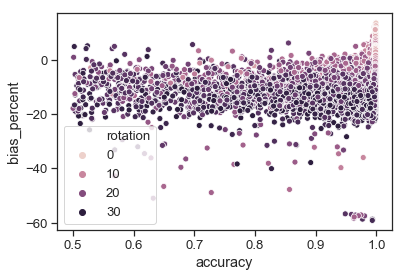

In [115]:
sns.scatterplot(x='accuracy', y='bias_percent', hue='rotation', data=df_hwratio)

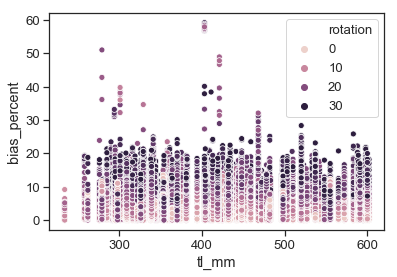

In [111]:
sns.scatterplot(x='tl_mm', y='bias_percent', hue='rotation', data=df_hwratio)

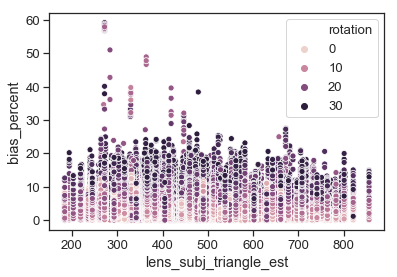

In [112]:
sns.scatterplot(x='lens_subj_triangle_est', y='bias_percent', hue='rotation', data=df_hwratio)

In [ ]:
#QUICK AGGREGATE OF ABS(rotation) < 16 to get CIs

In [10]:
sql = "SELECT CNN ,Transform ,abs(rotation) AS Angle ,Scale ,persp_corr_iter_profile_tridist_mm_error AS [Manual error] ,persp_corr_iter_profile_tridist_mm_error_perc AS [Manual error %] ,mv_persp_corr_iter_profile_tridist_mm_error AS [MV error] ,mv_persp_corr_iter_profile_tridist_mm_error_perc AS [MV error %] ,all_corr_rot_adj2_mm_error AS [MV adjusted error] ,all_corr_rot_adj2_mm_error_perc AS [MV adjusted error %] ,accuracy AS Score FROM v_mv_long_form WHERE (transform = 'None' OR rotation != 0) AND NOT mv_persp_corr_iter_profile_tridist_mm_error IS NULL AND accuracy > 0.5 AND abs(rotation) < 16 "

with mssql.Conn('imagedb', '(local)') as cnn:
    dfabsrot_ci = pd.read_sql(sql, cnn)
list(dfabsrot_ci)

['CNN',
 'Transform',
 'Angle',
 'Scale',
 'Manual error',
 'Manual error %',
 'MV error',
 'MV error %',
 'MV adjusted error',
 'MV adjusted error %',
 'Score']

In [14]:
#0-15%
dfabsrot_ci.groupby(['CNN']).agg({'MV adjusted error %':[np.mean, np.std, ci]})

MV adjusted error %                                       
                   mean       std                           ci
CNN                                                           
nas           -0.602841  4.189039  M=-0.6 95% CIs [-0.7, -0.5]
res           -1.698034  6.209327  M=-1.7 95% CIs [-1.8, -1.6]
ssd            2.791218  4.215576     M=2.8 95% CIs [2.7, 2.9]

In [15]:
sql = "SELECT CNN ,Transform ,abs(rotation) AS Angle ,Scale ,persp_corr_iter_profile_tridist_mm_error AS [Manual error] ,persp_corr_iter_profile_tridist_mm_error_perc AS [Manual error %] ,mv_persp_corr_iter_profile_tridist_mm_error AS [MV error] ,mv_persp_corr_iter_profile_tridist_mm_error_perc AS [MV error %] ,all_corr_rot_adj2_mm_error AS [MV adjusted error] ,all_corr_rot_adj2_mm_error_perc AS [MV adjusted error %] ,accuracy AS Score FROM v_mv_long_form WHERE (transform = 'None' OR rotation != 0) AND NOT mv_persp_corr_iter_profile_tridist_mm_error IS NULL AND accuracy > 0.5 AND abs(rotation) = 15 "

with mssql.Conn('imagedb', '(local)') as cnn:
    df15 = pd.read_sql(sql, cnn)
list(df15)

['CNN',
 'Transform',
 'Angle',
 'Scale',
 'Manual error',
 'Manual error %',
 'MV error',
 'MV error %',
 'MV adjusted error',
 'MV adjusted error %',
 'Score']

In [16]:
#0-15%
df15.groupby(['CNN']).agg({'MV adjusted error %':[np.mean, np.std, ci]})

MV adjusted error %                                       
                   mean       std                           ci
CNN                                                           
nas           -4.954648  4.250588  M=-5.0 95% CIs [-5.3, -4.6]
res           -5.317401  7.351767  M=-5.3 95% CIs [-5.9, -4.7]
ssd            2.735404  5.956561     M=2.7 95% CIs [2.2, 3.3]